In [6]:
import os
import subprocess
def module(*args):        
    if isinstance(args[0], list):        
        args = args[0]        
    else:        
        args = list(args)        
    (output, error) = subprocess.Popen(['/usr/bin/modulecmd', 'python'] + args, stdout=subprocess.PIPE).communicate()
    exec(output)    
module('load', 'apps/java/jdk1.8.0_102/binary')    
os.environ['PYSPARK_PYTHON'] = os.environ['HOME'] + '/.conda/envs/jupyter-spark/bin/python'

In [10]:
#making session.
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
spark = SparkSession.builder \
    .master("local[2]") \
    .appName("COM6012 Spark Intro") \
    .getOrCreate()

sc = spark.sparkContext

## Question 1(a) ##

In [11]:
#loading file
logFile=spark.read.text("Data/NASA_access_log_Jul95.gz").cache()

In [12]:
import pyspark.sql.functions as f #importing libraies.
#spliting by spaces.
split_col = f.split(logFile ['value'], ' ')
#Making column.
logFile = logFile.withColumn('a', split_col.getItem(0))
logFile = logFile.withColumn('b', split_col.getItem(1))
logFile = logFile.withColumn('c', split_col.getItem(2))
logFile = logFile.withColumn('date', split_col.getItem(3))
logFile = logFile.withColumn('e', split_col.getItem(4))
logFile = logFile.withColumn('f', split_col.getItem(5))
logFile = logFile.withColumn('request', split_col.getItem(6))
logFile = logFile.withColumn('h', split_col.getItem(6))
logFile = logFile.withColumn('i', split_col.getItem(7))
logFile = logFile.withColumn('j', split_col.getItem(8))

In [13]:
#transforming date and droping useless column.
split_col = f.split(logFile ['date'], ':')
logFile = logFile.withColumn('date', split_col.getItem(0))
f1 = logFile.drop('value')
f2 = f1.drop('j')
f3 = f2.drop('b')
f4 = f3.drop('c')
f5 = f4.drop('e')
f6 = f5.drop('d')
split_col = f.split(f6 ['date'], '\[')
f6 = f6.withColumn('date', split_col.getItem(1))
request_count=f6.select('request').count()

In [14]:
#changing date format and finding days.
new_date_format = f6.withColumn("transformed_date", regexp_replace('date','/Jul/','-07-'))
new_date_format = new_date_format.withColumn('new_transformed_date', to_date('transformed_date', 'dd-MM-yyyy'))
new_date_format = new_date_format.withColumn('Day', date_format('new_transformed_date','E'))
Day_Count = new_date_format.groupBy('Day').count()
Day_Count = Day_Count.where(Day_Count.Day.isNotNull())
Day_Count.show()

+---+------+
|Day| count|
+---+------+
|Sun|182590|
|Mon|301684|
|Thu|363436|
|Sat|184380|
|Wed|318698|
|Tue|277840|
|Fri|263086|
+---+------+



In [21]:
# to find the averge dividing each total of request with count of number.
acurracy_sun=182590/4
acurracy_mon=301684/4
acurracy_tues=277840/4
acurracy_wed=318698/4
acurracy_thurs=363436/4
acurracy_fri=263086/4
acurracy_sat=184380/4

print("Accuracy on Sunday",acurracy_sun)
print("Accuracy on Monday",acurracy_mon)
print("Accuracy on Tuesday",acurracy_tues)
print("Accuracy on Wednesday",acurracy_wed)
print("Accuracy on Thursday",acurracy_thurs)
print("Accuracy on Friday",acurracy_fri)
print("Accuracy on Saturday",acurracy_sat)

Accuracy on Sunday 45647.5
Accuracy on Monday 75421.0
Accuracy on Tuesday 69460.0
Accuracy on Wednesday 79674.5
Accuracy on Thursday 90859.0
Accuracy on Friday 65771.5
Accuracy on Saturday 46095.0


## Question 1(b) ##

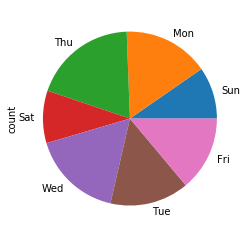

In [22]:
import matplotlib
import matplotlib.pyplot as plot
% matplotlib inline

visualise_count = Day_Count.toPandas()
visualise_count.plot(kind = 'pie', y = 'count', labels = visualise_count['Day'] ,legend = False)

## Question 1 (c) ##

In [23]:
# top 20 most requested .gif images.
request_count_top20=f6.select('request')
request_count__top20 = request_count_top20.filter(logFile.value.contains(".gif"))
request__count__top20 = request_count__top20.groupBy("request").count()
requester=request__count__top20.orderBy("count", ascending=False)
requester.show(20,False)     

+---------------------------------------------------+------+
|request                                            |count |
+---------------------------------------------------+------+
|/images/NASA-logosmall.gif                         |111144|
|/images/KSC-logosmall.gif                          |89530 |
|/images/MOSAIC-logosmall.gif                       |60300 |
|/images/USA-logosmall.gif                          |59845 |
|/images/WORLD-logosmall.gif                        |59325 |
|/images/ksclogo-medium.gif                         |58616 |
|/images/launch-logo.gif                            |40841 |
|/images/ksclogosmall.gif                           |33555 |
|/history/apollo/images/apollo-logo1.gif            |31052 |
|/shuttle/countdown/count.gif                       |22189 |
|/shuttle/countdown/count70.gif                     |20921 |
|/images/launchmedium.gif                           |20788 |
|/shuttle/missions/sts-71/sts-71-patch-small.gif    |19832 |
|/shuttle/missions/sts-7

## Question 1(d) ##

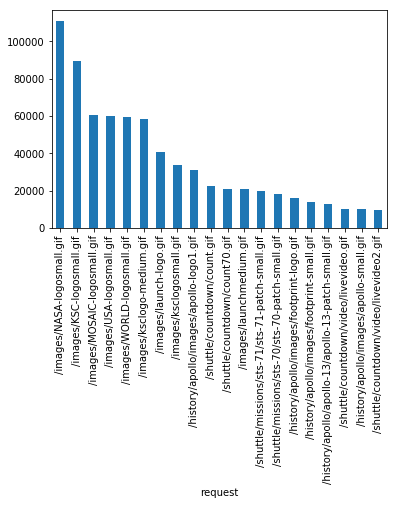

In [24]:
requesttop20 = requester.limit(20).toPandas()
requesttop20.plot(kind = 'bar', y = 'count', x = 'request',legend = False)

## Question 2(a) ##

In [15]:
#importing libraries.
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

In [18]:
#loading csv file.
df = spark.read.load("Data/ratings.csv",format="csv", inferSchema="true", header="true")

In [19]:
#Spliting Data into 5 parts and then using 4 for training and one for testing.  
five_fold_cross_validation=5
five_fold_cross_validation_list=[]
for i in range(five_fold_cross_validation):    
    parts=1/five_fold_cross_validation
    five_fold_cross_validation_list.append(parts)
five_fold_cross_validation_list_updated = df.randomSplit(five_fold_cross_validation_list)
print(five_fold_cross_validation_list_updated)

[DataFrame[userId: int, movieId: int, rating: double, timestamp: int], DataFrame[userId: int, movieId: int, rating: double, timestamp: int], DataFrame[userId: int, movieId: int, rating: double, timestamp: int], DataFrame[userId: int, movieId: int, rating: double, timestamp: int], DataFrame[userId: int, movieId: int, rating: double, timestamp: int]]


In [20]:
#importing libraries.
from functools import reduce  
from pyspark.sql import DataFrame
#list
rmse_drop1_list = [] #RMSE drop1 list.
mae_drop1_list = [] #MAE drop1 list.
rmse_drop2_list = [] #RMSE drop2 list.
mae_drop2_list = [] #MAE drop2 list.
no_of_item=[] #No of Items.

def unionAll(*df):
    return reduce(DataFrame.unionAll, df)
k=5
for i in range(k): # runing training and testing at every iteration.
    x_test=five_fold_cross_validation_list_updated[i] #moving one part in test data.
    nlist = [x for k,x in enumerate(five_fold_cross_validation_list_updated) if k!=i]  
    nlist_1=nlist[0]
    for kk in nlist[1:]: #combining 4 parts for training.
        nlist_1=nlist_1.union(kk)
    x_train=nlist_1
    # Used content from lab 3 for refernce.
    #2 approch drop1 and drop2.
    als_drop1 = ALS(maxIter=10, userCol="userId", regParam=0.6,itemCol="movieId", ratingCol="rating",coldStartStrategy="drop")
    als_drop2 = ALS(maxIter=10, userCol="userId", regParam=0.1, itemCol="movieId", ratingCol="rating",coldStartStrategy="drop")
    #Training model on both approach.
    model_drop1 = als_drop1.fit(x_train) 
    model_drop2 = als_drop2.fit(x_train)
    #appending data into items list, to be used in next part.
    no_of_item.append(model_drop1.itemFactors)
    #doing prediction on testing for both approcah.
    predictions_drop1 = model_drop1.transform(x_test)
    predictions_drop2 = model_drop2.transform(x_test)
    #'RMSE' and 'MAE' for drop1.
    evaluator_rmse_drop1 = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
    rmse_drop1 = evaluator_rmse_drop1.evaluate(predictions_drop1)
    rmse_drop1_list.append(rmse_drop1)
    evaluator_mae_drop1 = RegressionEvaluator(metricName="mae", labelCol="rating",predictionCol="prediction")
    mae_drop1 = evaluator_mae_drop1.evaluate(predictions_drop1)
    mae_drop1_list.append(mae_drop1)
    #'RMSE' and 'MAE' for drop2.
    evaluator_rmse_drop2 = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
    rmse_drop2 = evaluator_rmse_drop2.evaluate(predictions_drop2)
    rmse_drop2_list.append(rmse_drop2)
    evaluator_mae_drop2 = RegressionEvaluator(metricName="mae", labelCol="rating",predictionCol="prediction")
    mae_drop2 = evaluator_mae_drop2.evaluate(predictions_drop2)
    mae_drop2_list.append(mae_drop2)
#printing list.
print("List of rmse for drop1",rmse_drop1_list)
print("List of mae for drop1",mae_drop1_list)
print("List of rmse for drop2",rmse_drop2_list)
print("List of mae for drop2",mae_drop2_list) 

List of rmse for drop1 [1.050706171498528, 1.0507565280032019, 1.0508653205949694, 1.051141300680862, 1.0513950426948144]
List of mae for drop1 [0.8763318944595654, 0.8765855599065437, 0.8766300446900048, 0.8767435075444302, 0.8771588037089416]
List of rmse for drop2 [0.80815830555369, 0.8085078972870579, 0.8088266317616041, 0.80855572868725, 0.8091606884616688]
List of mae for drop2 [0.6295272803562297, 0.6298531839523294, 0.6301397896448747, 0.6298115012855368, 0.630190087922438]


In [29]:
import numpy as np #importing libraries.
#Mean and Standard Deviation for both the approach.
averge_rmse_drop1_list=np.sum(rmse_drop1_list)/5
standard_deviation_averge_rmse_drop1_list =np.std(rmse_drop1_list)
print("Averge of rmse for coldStartStrategy(drop1)",averge_rmse_drop1_list)
print("Standard deviation of rmse for coldStartStrategy(drop1)",standard_deviation_averge_rmse_drop1_list)
averge_mae_drop1_list=np.sum(mae_drop1_list)/5
standard_deviation_averge_mae_drop1_list =np.std(mae_drop1_list)
print("Averge of mae for coldStartStrategy(drop1)",averge_mae_drop1_list)
print("Standard deviation of rmse for coldStartStrategy(drop1)",standard_deviation_averge_mae_drop1_list)
averge_rmse_drop2_list=np.sum(rmse_drop2_list)/5 
standard_deviation_averge_rmse_drop2_list =np.std(rmse_drop2_list)
print("Averge of rmse for coldStartStrategy(drop2)",averge_rmse_drop2_list)
print("Standard deviation of rmse for coldStartStrategy(drop2)",standard_deviation_averge_rmse_drop2_list)
averge_mae_drop2_list=np.sum(mae_drop2_list)/5
standard_deviation_averge_mae_drop2_list =np.std(mae_drop2_list)
print("Averge of mae for coldStartStrategy(drop2)",averge_mae_drop2_list)
print("Standard deviation of mae for coldStartStrategy(drop2)",standard_deviation_averge_mae_drop2_list)

Averge of rmse for coldStartStrategy(drop1) 1.05097287269
Standard deviation of rmse for coldStartStrategy(drop1) 0.000259267237905
Averge of mae for coldStartStrategy(drop1) 0.876689962062
Standard deviation of rmse for coldStartStrategy(drop1) 0.000270326438973
Averge of rmse for coldStartStrategy(drop2) 0.80864185035
Standard deviation of rmse for coldStartStrategy(drop2) 0.000335414099316
Averge of mae for coldStartStrategy(drop2) 0.629904368632
Standard deviation of mae for coldStartStrategy(drop2) 0.00024103873109


## Question 2(c) ##
Note: Question 2(b and d) in the report

In [30]:
#importing libraries.
from pyspark.sql import functions as F
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import col
#list.
list_of_movies=[]
three_large_cluster=3
#reading file.
genome_tag_df = spark.read.load("Data/ml-20m/genome-tags.csv",format="csv", inferSchema="true", header="true")
genome_scores_df = spark.read.load("Data/ml-20m/genome-scores.csv",format="csv", inferSchema="true", header="true")
movie_vector=udf(lambda a: Vectors.dense(a), VectorUDT())
# Iterating it 15 times.
for i in range(len(no_of_item)):
    id_for_item=[]
    dataframe=no_of_item[i].withColumn('dense_vec', movie_vector('features'))
    dataframe_1=dataframe.drop('features')
    dataframe_2=dataframe_1.selectExpr("id as id","dense_vec as features")
    k_mean=KMeans().setK(20).setSeed(1) #kmean for clustering where k=20 as asked.
    k_mean_model= k_mean.fit(dataframe_2)
    k_mean_model_transformation=k_mean_model.transform(dataframe_2)
    k_mean_grouping=k_mean_model_transformation.groupBy("prediction").count().sort(col("count").desc()).limit(3)
    k_mean_top_three=[int(row.prediction) for row in k_mean_grouping.collect()]
    for i in range(three_large_cluster):
        input_kmean=k_mean_model_transformation.prediction == k_mean_top_three[i]
        clustering_id = k_mean_model_transformation.filter(input_kmean)
        clustering_id_1=[int(row.id) for row in clustering_id.collect()]
        id_for_item.append(clustering_id_1)
    list_of_movies.append(id_for_item)

In [31]:
#to find the top five tags for each of the top three largest clusters.
for a in list_of_movies:
    for b in a:
        i = list_of_movies.index(a)+1
        print('splitting :'+str(i))
        print('clustering :'+str(a.index(b)+1))
        movies=genome_scores_df.where(genome_scores_df.movieId.isin(b))
        tag=movies.groupBy('tagId').agg(F.sum("relevance")).sort(col('sum(relevance)').desc()).limit(5)
        Id_tag_list=[int(row.tagId) for row in tag.collect()]
        final_tag = genome_tag_df.where(genome_tag_df.tagId.isin(Id_tag_list))
        #if i < 6:
        final_tag.show(5)
        

splitting :1
clustering :1
+-----+---------------+
|tagId|            tag|
+-----+---------------+
|  302|       dialogue|
|  452|good soundtrack|
|  468|   great ending|
|  646|         mentor|
|  742|       original|
+-----+---------------+

splitting :1
clustering :2
+-----+---------------+
|tagId|            tag|
+-----+---------------+
|  302|       dialogue|
|  452|good soundtrack|
|  468|   great ending|
|  646|         mentor|
|  742|       original|
+-----+---------------+

splitting :1
clustering :3
+-----+------------+
|tagId|         tag|
+-----+------------+
|  188| catastrophe|
|  302|    dialogue|
|  468|great ending|
|  646|      mentor|
|  742|    original|
+-----+------------+

splitting :2
clustering :1
+-----+---------------+
|tagId|            tag|
+-----+---------------+
|  302|       dialogue|
|  452|good soundtrack|
|  468|   great ending|
|  646|         mentor|
|  742|       original|
+-----+---------------+

splitting :2
clustering :2
+-----+---------------+
